# MODELO DE MACHINE LEARNING PARA PREVISÃO DE DOENÇAS CARDÍACAS

#### Link do projeto original: https://www.youtube.com/watch?v=bG9c7wntKP0&list=PLI-bpOj6_aWGz89aONnhAUT3GpMP2VvW7&index=20

## Dados do projeto:

#### Os dados a seguir são parâmetros utilizados em uma avaliação cardiológica

##### 1 - Age: idade do paciente[anos]
##### 2 - Sex: sexo do paciente[M: Masculino, F: Feminino]
##### 3 - ChestPainType: tipo de dor torácica [TA:Angina típica, ATA: Angina atípica, NAP: Dor não angiosa, ASY: Assintomática]
##### 4 - RestingBP: Pressão arterial em repouso [mm Hg]
##### 5 - Cholesterol: Colesterol sérico [mm/dl]
##### 6 - FastingBS: Glicemia em jejum [1:se BS em jejum > 120 mg/dl, 0: caso contrário]
##### 7 - RestingECG: resultados do eletrocardiograma em repouso [Normal: Normal, ST: com anormalidade das ondas ST-T (inversões das ondas T e/ou elevação ou depressão de ST > 0,05 mV), HVE: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de testes]
##### 8 - MaxHR: Frequência cardíaca máxima alcançada [valor numérico entre 60 e 202]
##### 9 - ExercícioAngina: Angina induzida por exercício [Y:Sim, N:Não]
##### 10 - Oldpeak: oldpeak = ST [Valor numérico medido na depressão]
##### 11 - ST_Slope: A inclinação do segmento ST do pico do exercício [Up: subida, Fiat: fiat, Down: downsloping]
##### 12 - HearthDisease: Classe de saída [1: doença cardíaca, 0: Normal]\

In [6]:
# Importando os pacotes que serão utilizados

import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, accuracy_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format

In [7]:
# Carregando o arquivo CSV

df_original = pd.read_csv('heart.csv')

In [8]:
# Verificando as linhas do nosso DataFrame

df_original.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.00,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.00,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.00,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.50,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.00,Up,0


In [9]:
# Verificando as dimensões do arquivo

df_original.shape

(918, 12)

In [10]:
# Verificando informações do arquivo

df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [11]:
# Verificando se há valores nulos

df_original.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [12]:
# Total de valores únicos de cada variável

valores_unicos = []
for i in df_original.columns[0:12].tolist():
    print(i, ':', len(df_original[i].astype(str).value_counts()))
    valores_unicos.append(len(df_original[i].astype(str).value_counts()))

Age : 50
Sex : 2
ChestPainType : 4
RestingBP : 67
Cholesterol : 222
FastingBS : 2
RestingECG : 3
MaxHR : 119
ExerciseAngina : 2
Oldpeak : 53
ST_Slope : 3
HeartDisease : 2


In [13]:
# Visualizando algumas medidas estatistícas

df_original.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


In [14]:
# Quantidade de observações por Sexo
df_original.groupby(['Sex']).size()

Sex
F    193
M    725
dtype: int64

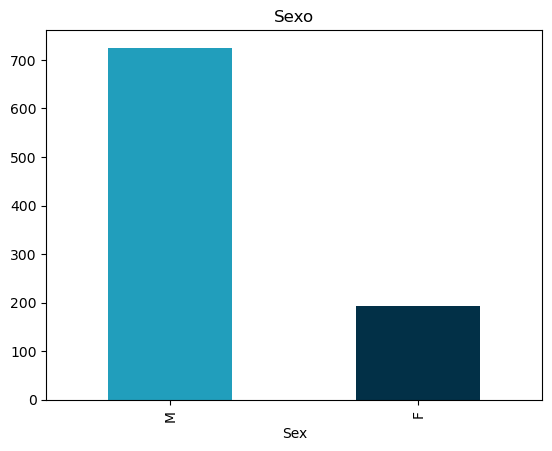

In [15]:
# Visualizando através do gráfico

df_original.Sex.value_counts().plot(kind='bar', title='Sexo', color = ['#219ebc', '#023047']);

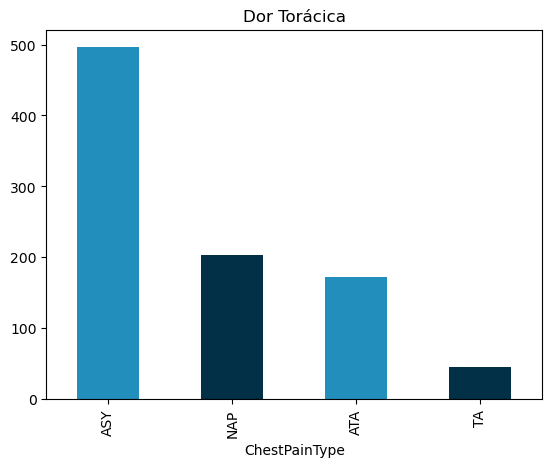

In [16]:
# Quantidade de observações por Dor Torácica

df_original.ChestPainType.value_counts().plot(kind= 'bar', title= 'Dor Torácica', color = ['#218ebc', '#023047']);

In [17]:
# Quantidade de observações por Glicemia em Jejum
df_original.groupby(['FastingBS']).size()

FastingBS
0    704
1    214
dtype: int64

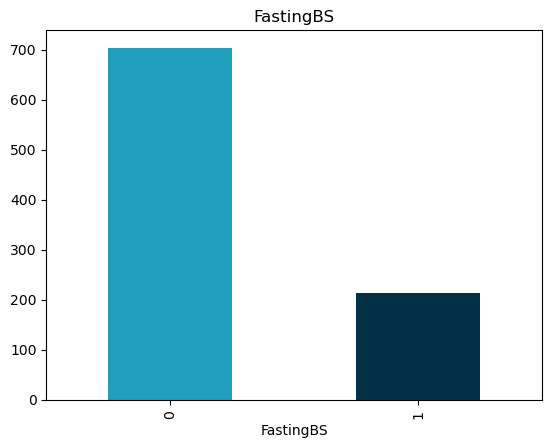

In [18]:
# Visualizando através do gráfico
df_original.FastingBS.value_counts().plot(kind='bar', title='FastingBS',color = ['#219ebc', '#023047']);

In [19]:
# Quantidade de observações por Tipo de Dor Toraxica
df_original.groupby(['RestingECG']).size()

RestingECG
LVH       188
Normal    552
ST        178
dtype: int64

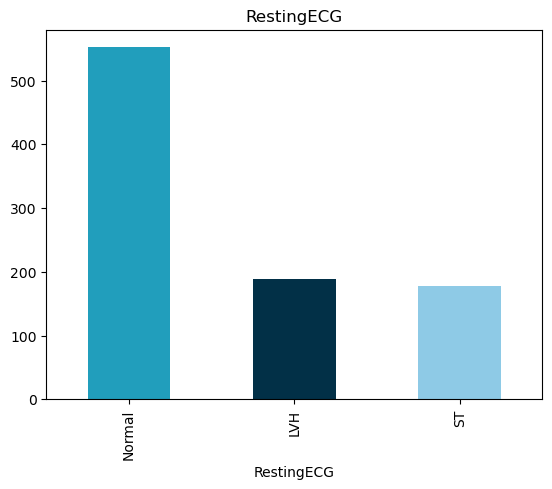

In [20]:
# Visualizando através do gráfico
df_original.RestingECG.value_counts().plot(kind='bar' , title='RestingECG',color = ['#219ebc', '#023047', '#8ecae6']);

In [21]:
# Quantidade de observações por Angina Induzida
df_original.groupby(['ExerciseAngina']).size()

ExerciseAngina
N    547
Y    371
dtype: int64

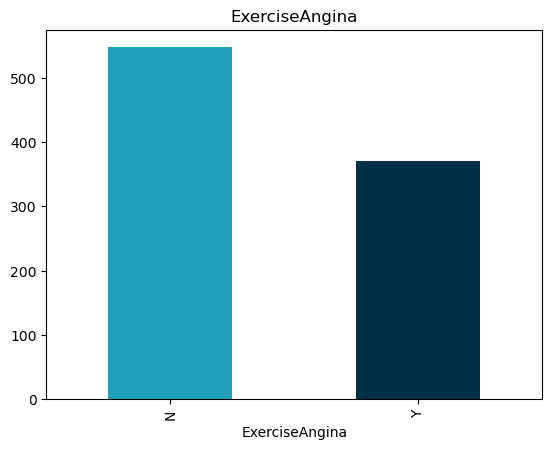

In [22]:
# Visualizando através do gráfico
df_original.ExerciseAngina.value_counts().plot(kind='bar', title='ExerciseAngina',color = ['#219ebc', '#023047']);

In [23]:
# Quantidade de observações Inclinação Pico Exercício
df_original.groupby(['ST_Slope']).size()

ST_Slope
Down     63
Flat    460
Up      395
dtype: int64

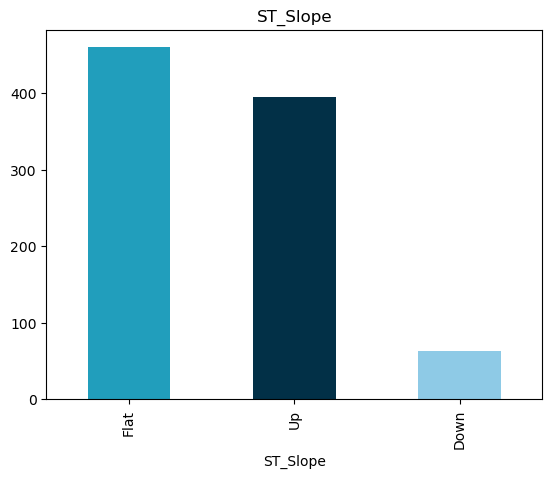

In [24]:
# Visualizando através do gráfico
df_original.ST_Slope.value_counts().plot(kind='bar', title='ST_Slope',color = ['#219ebc', '#023047', '#8ecae6']);

In [25]:
# Quantidade de observações Doença Cardiaca (Variável TARGET)
df_original.groupby(['HeartDisease']).size()

HeartDisease
0    410
1    508
dtype: int64

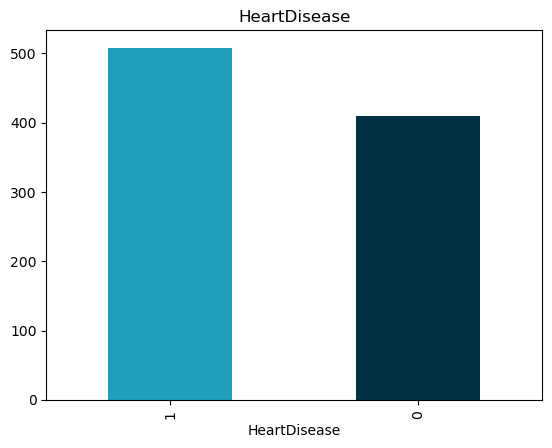

In [26]:
df_original.HeartDisease.value_counts().plot(kind='bar', title='HeartDisease',color = ['#219ebc', '#023047']);

# Analisando Variáveis categóricas em relação à variável alvo

In [28]:
# Formatando o tamanho do plot
plt.rcParams["figure.figsize"] = [8.00, 4.00]
plt.rcParams["figure.autolayout"] = True

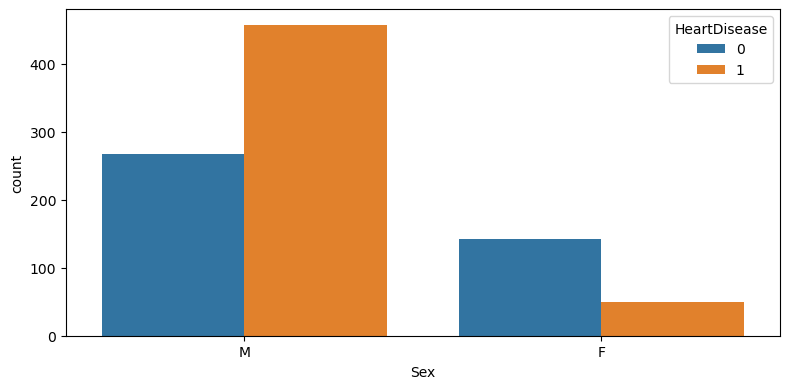

In [29]:
# Visualizando a Variável Sex x HeartDisease

sns.countplot(data = df_original, x = "Sex", hue = "HeartDisease")
plt.show()

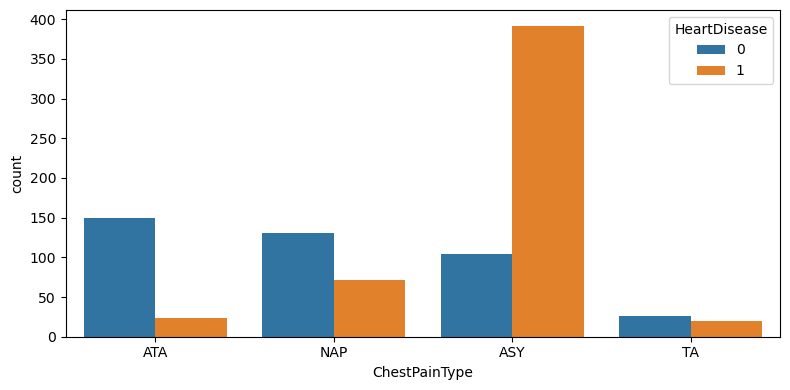

In [30]:
# Visualizando a Variável ChestPainType x HeartDisease

sns.countplot(data = df_original, x = "ChestPainType", hue = "HeartDisease")
plt.show()

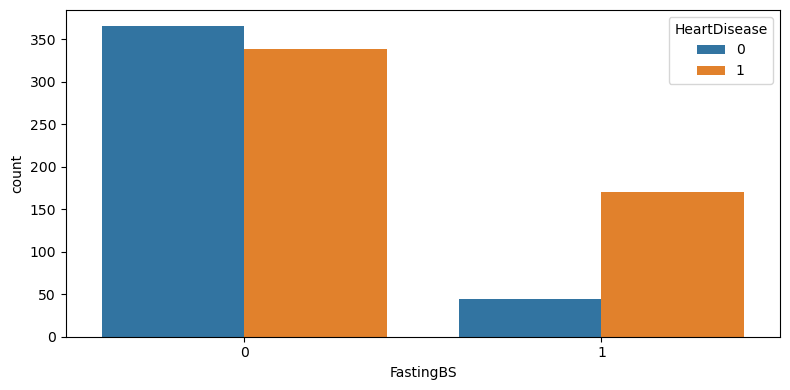

In [31]:
# Visualizando a Variável FastingBS x HeartDisease

sns.countplot(data = df_original, x = "FastingBS", hue = "HeartDisease")
plt.show()

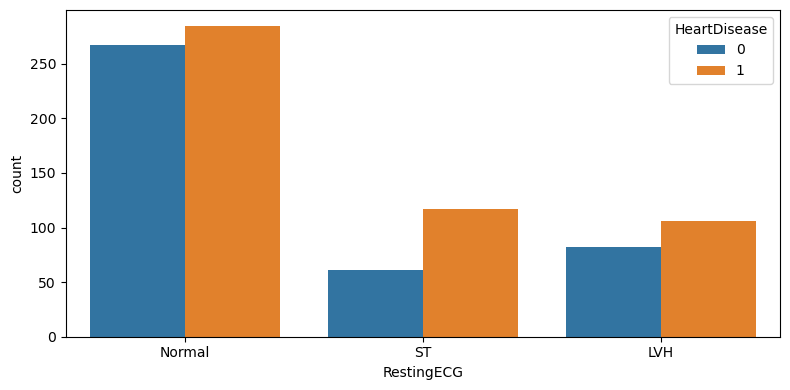

In [32]:
# Visualizand0 a Variável RestingECG x HeartDisease

sns.countplot(data = df_original, x = "RestingECG", hue = "HeartDisease")
plt.show()

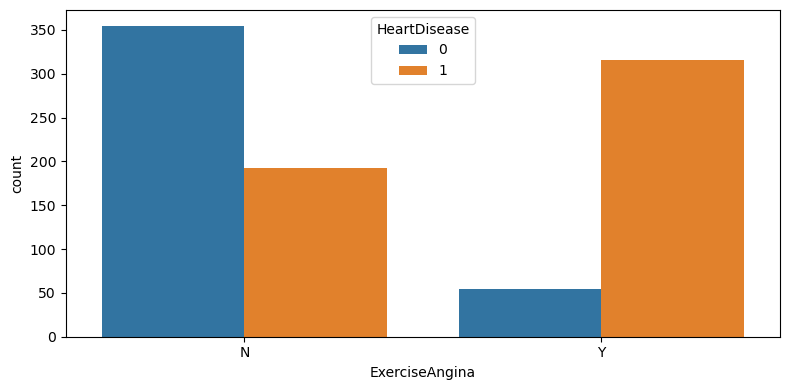

In [33]:
# Visualizando a Variável ExerciseAngina x HeartDisease

sns.countplot(data = df_original, x = "ExerciseAngina", hue = "HeartDisease")
plt.show()

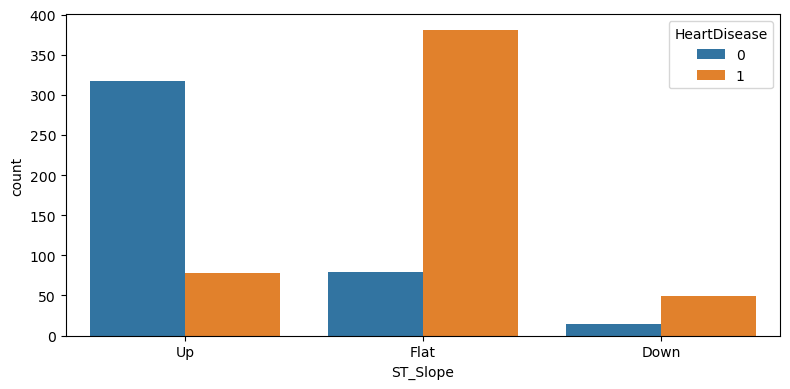

In [34]:
# Visualizando a Variável ST_Slope x HeartDisease

sns.countplot(data = df_original, x = "ST_Slope", hue = "HeartDisease")
plt.show()

In [35]:
# Convertendo as variáveis do tipo Object para Category

df_original['Sex'] = df_original['Sex'].astype('category')
df_original['ChestPainType'] = df_original['ChestPainType'].astype('category')
df_original['RestingECG'] = df_original['RestingECG'].astype('category')
df_original['ExerciseAngina'] = df_original['ExerciseAngina'].astype('category')
df_original['ST_Slope'] = df_original['ST_Slope'].astype('category')
df_original['FastingBS'] = df_original['FastingBS'].astype('category')

In [36]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    category
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(6), float64(1), int64(5)
memory usage: 49.4 KB


In [37]:
# Carregar variáveis para plot
variaveis_numericas = []
for i in df_original.columns[0:11].tolist():
    if df_original.dtypes[i] == 'int64' or df_original.dtypes[i] == 'float64':
        variaveis_numericas.append(i)

In [38]:
variaveis_numericas

['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

In [39]:
len(variaveis_numericas)

5

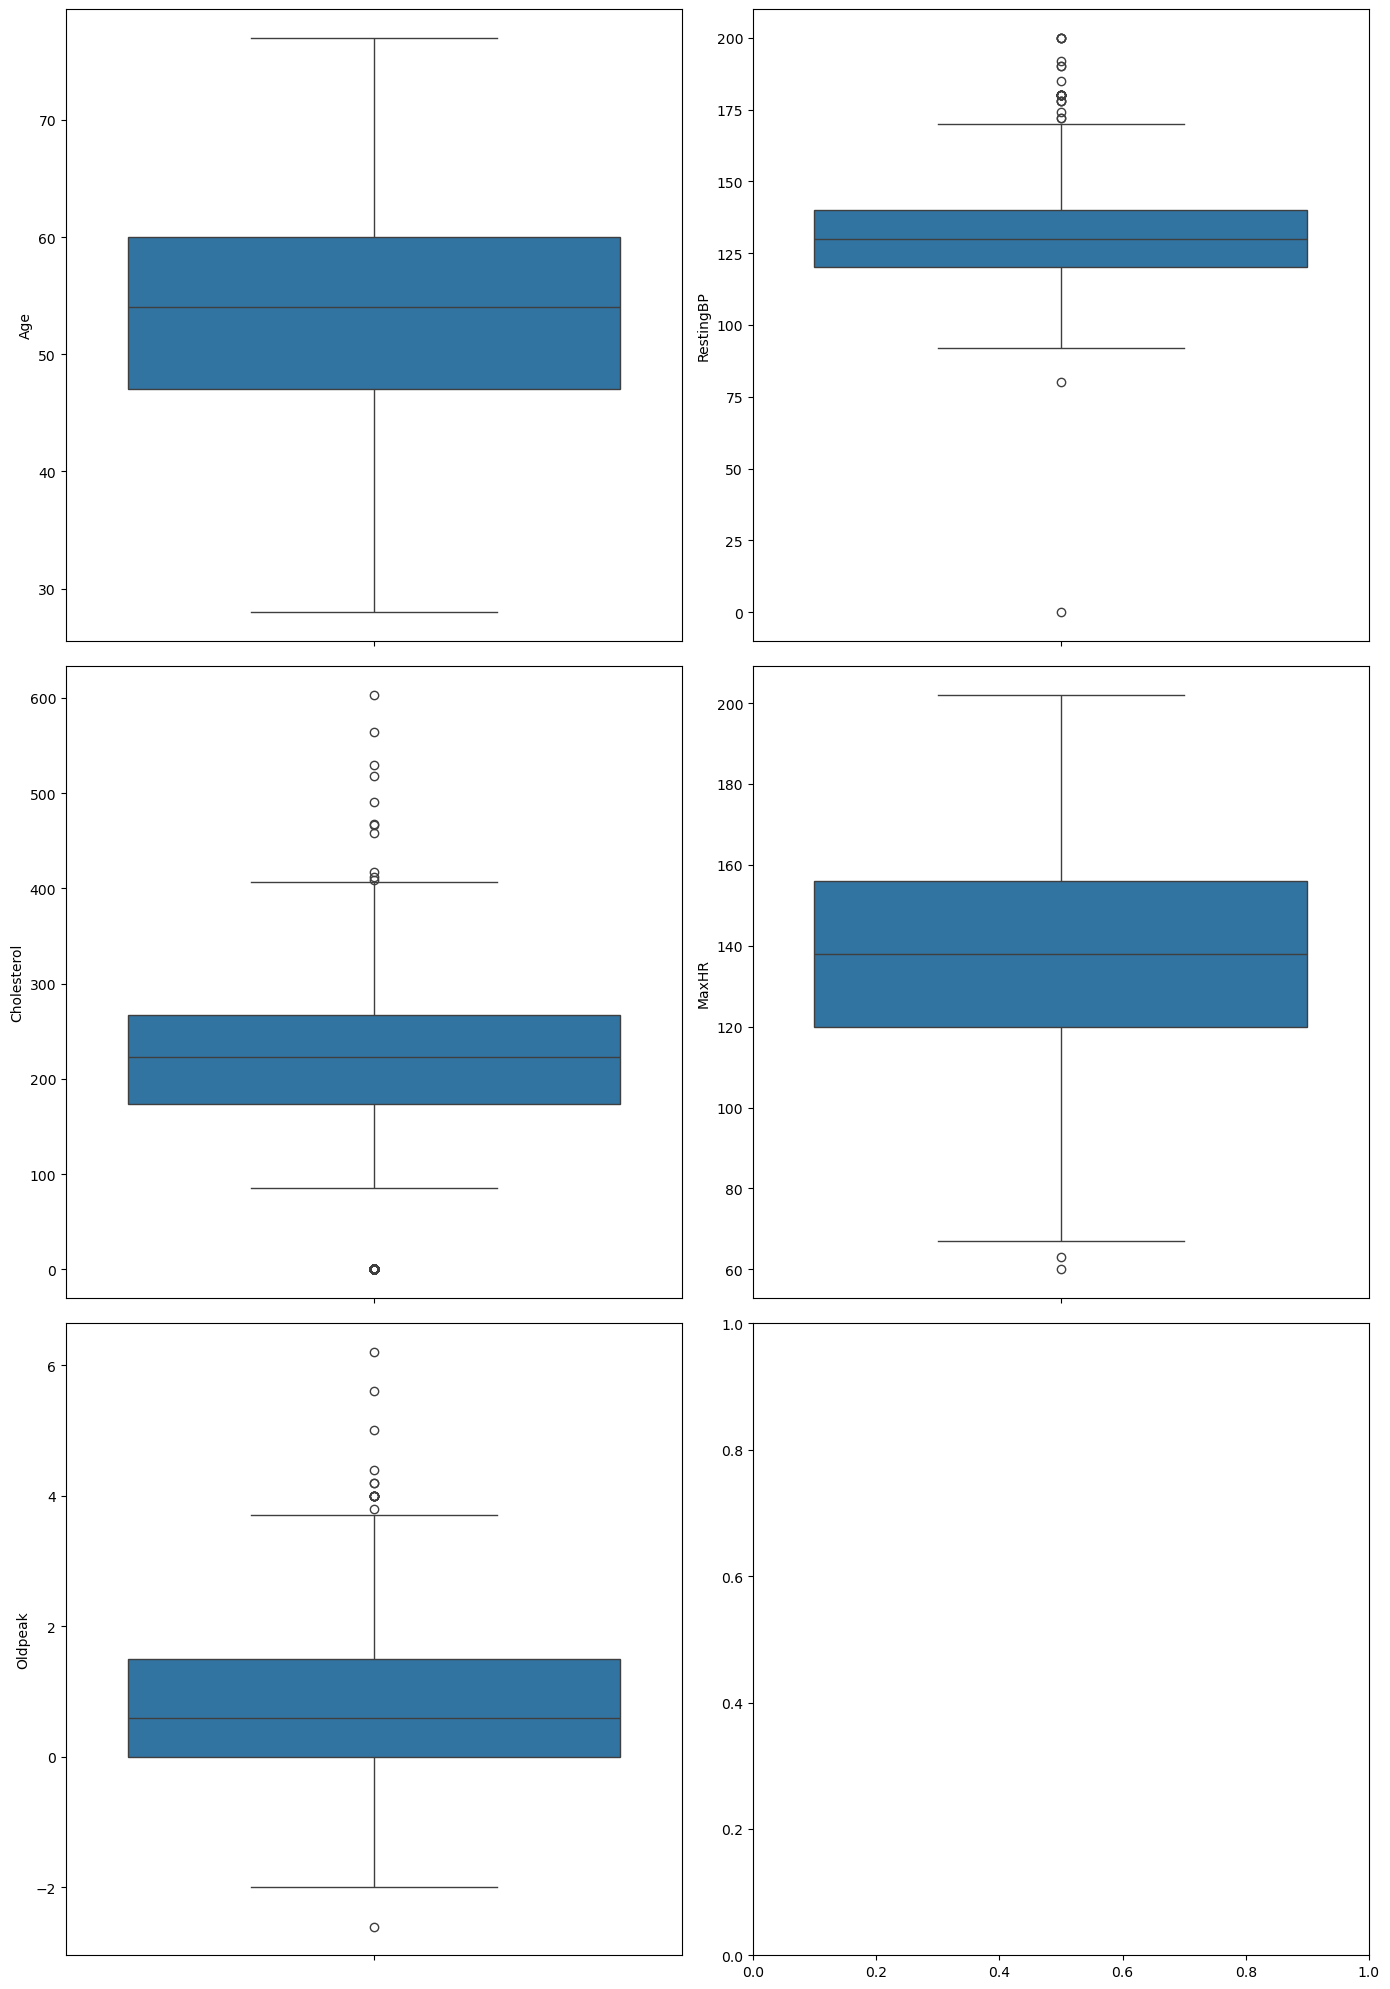

In [40]:
# Podemos observar nos boxplots abaixo que as variáveis numéricas apresentam uma grande quantidade de "possíveis" outliers
# Precisamos avaliar cada uma dessas variáveis dentro do contexto dos dados para saber se realmente iremos trata-las como outlier

plt.rcParams["figure.figsize"] = [14.00, 20.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(3, 2) #3 linhas e 2 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.boxplot(data = df_original, y=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 2:
        linha += 1
        coluna = 0

plt.show()

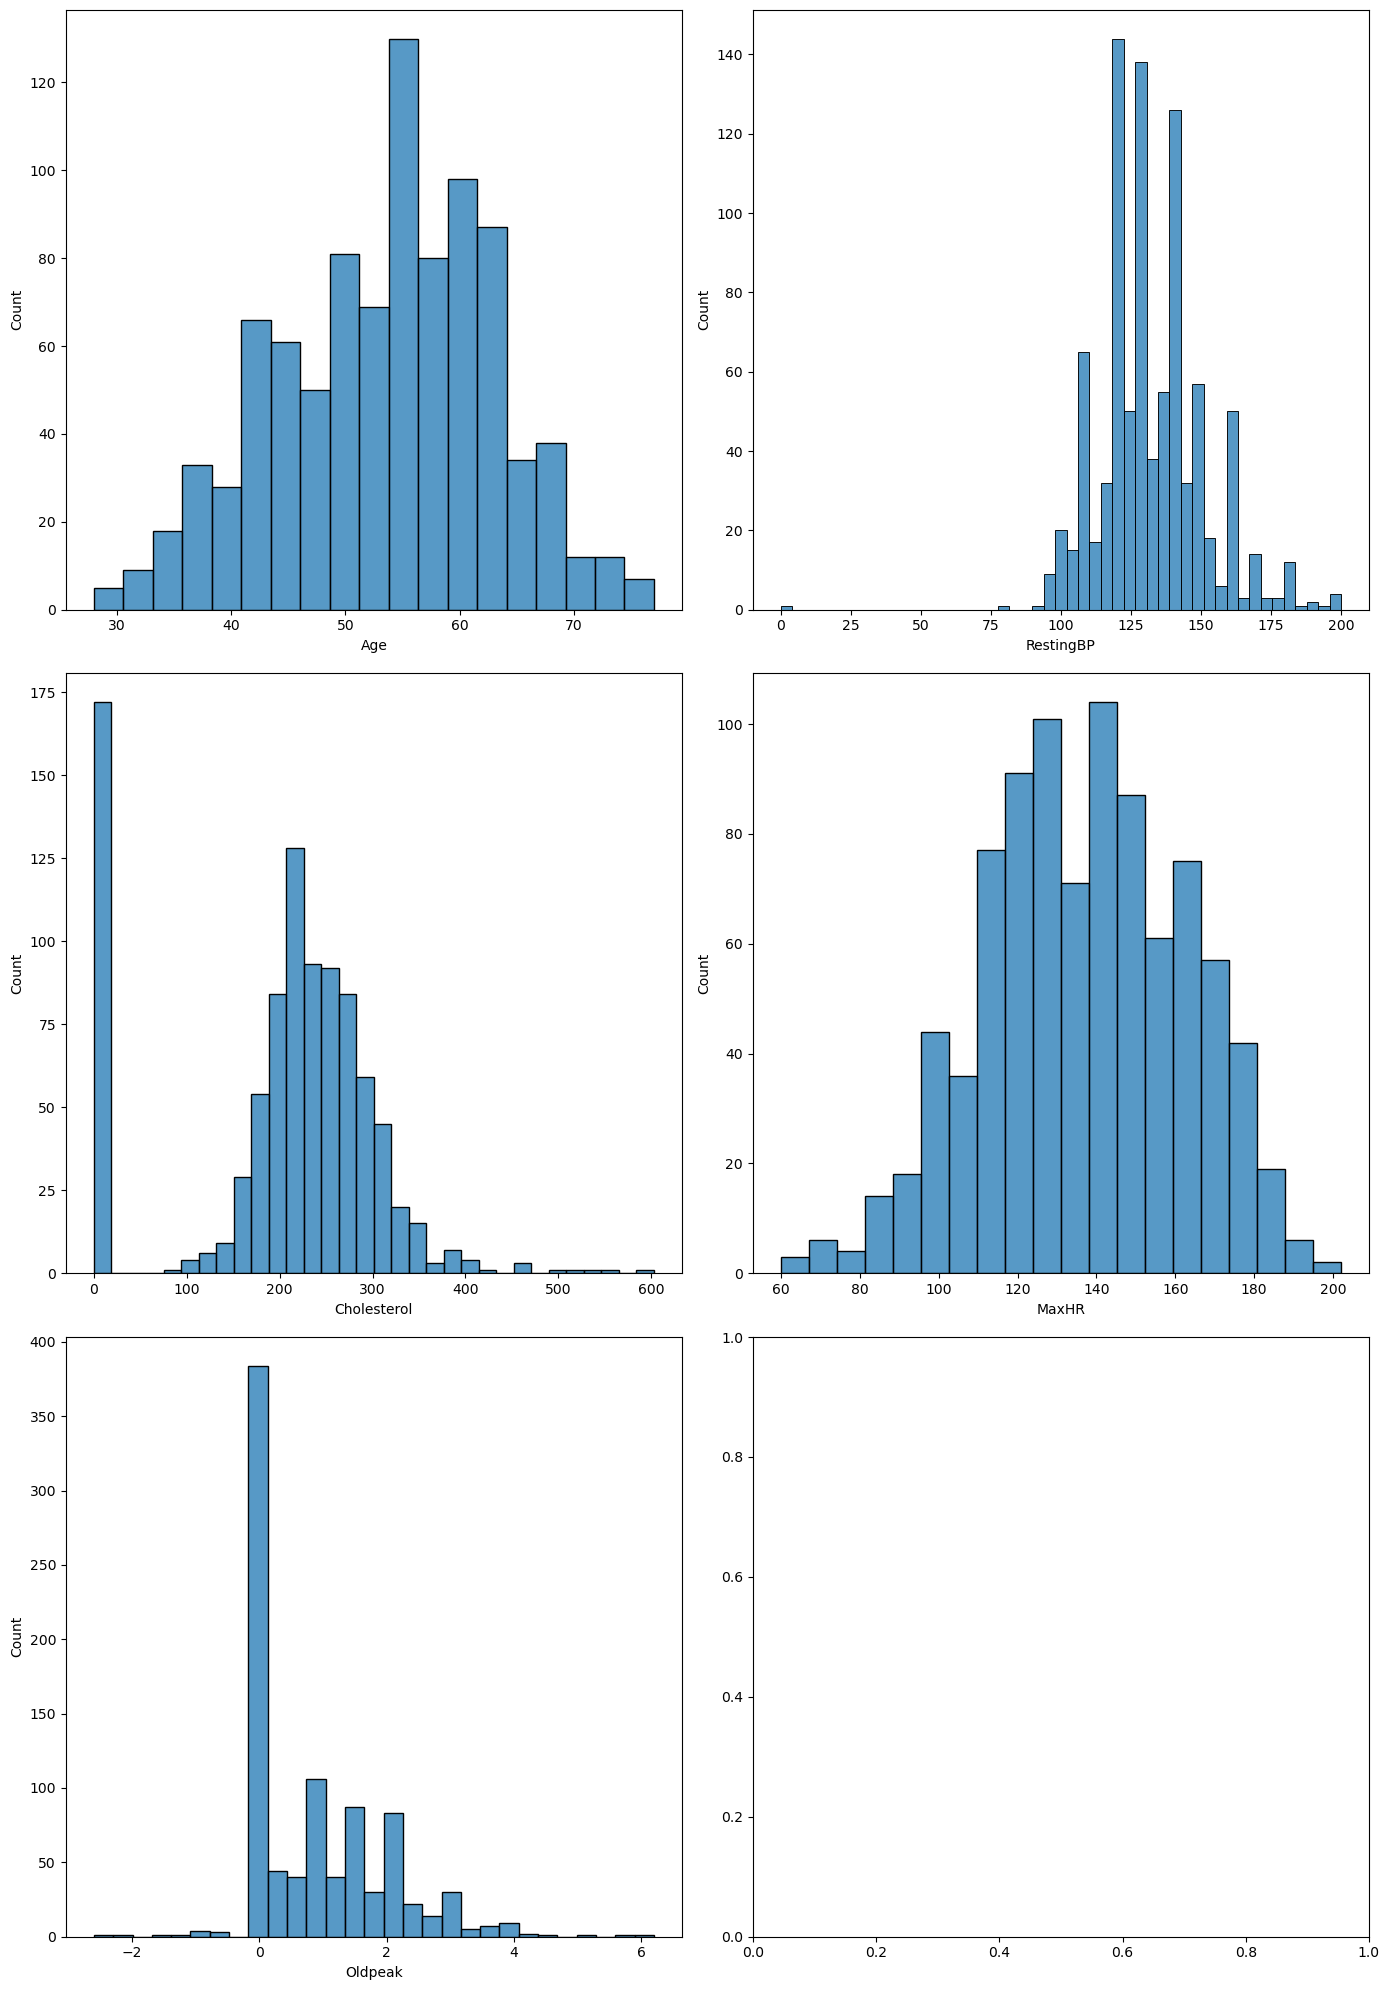

In [41]:
#Podemos observar nos boxplots abaixo que as variáveis númericas apresentam uma grande quantidade de "possíveis" outliers
#Precisamos avaliar cada uma dessas variaveis dentro do contexto dos dados para saber se realmente iremos trata-las como outlier

plt.rcParams["figure.figsize"] = [14.00, 20.00]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(3, 2) #3 linhas e 2 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
    sns.histplot(data = df_original, x=i, ax=axes[linha][coluna])
    coluna += 1
    if coluna == 2:
        linha += 1
        coluna = 0

plt.show()

In [42]:
# carregar variaveis categoricas para OneHotEncoding
# Vamos colocar o slice somente até a coluna de indice 18 para não pegar a variável target.
variaveis_categoricas = []
for i in df_original.columns[0:11].tolist():
    if df_original.dtypes[i] == 'object' or df_original.dtypes[i] == 'category':
        variaveis_categoricas.append(i)

In [43]:
# Visualizando as variaveis categóricas
variaveis_categoricas

['Sex',
 'ChestPainType',
 'FastingBS',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope']

In [44]:
# Cria o encoder e aplica OneHotEncoder
lb = LabelEncoder()

for var in variaveis_categoricas:
    df_original[var] = lb.fit_transform(df_original[var])

In [45]:
# Verifica novamente para confirmar se após transformação surgiu algum valor nulo
df_original.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [46]:
# Visualizando os tipos de variaveis
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int32  
 2   ChestPainType   918 non-null    int32  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int32  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int32  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int32  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int32(5), int64(6)
memory usage: 68.3 KB


In [47]:
df_original.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.00,2,0
1,49,0,2,160,180,0,1,156,0,1.00,1,1
2,37,1,1,130,283,0,2,98,0,0.00,2,0
3,48,0,0,138,214,0,1,108,1,1.50,1,1
4,54,1,2,150,195,0,1,122,0,0.00,2,0


In [48]:
# Visualizando a quantidade da variável target para balanceamento
variavel_target = df_original.HeartDisease.value_counts()
variavel_target

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [49]:
# Separar variáveis preditoras e target
PREDITORAS = df_original.iloc[:, 0:11]
TARGET = df_original.iloc[:, 11]

In [50]:
# Visualizando as variaveis preditoras
PREDITORAS.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,40,1,1,140,289,0,1,172,0,0.00,2
1,49,0,2,160,180,0,1,156,0,1.00,1
2,37,1,1,130,283,0,2,98,0,0.00,2
3,48,0,0,138,214,0,1,108,1,1.50,1
4,54,1,2,150,195,0,1,122,0,0.00,2


In [51]:
# Visualizadno a variavel target
TARGET.head()

0    0
1    1
2    0
3    1
4    0
Name: HeartDisease, dtype: int64

In [52]:
# Seed para reproduzir o mesmo resultado
seed = 100

# Cria o balanceador SMOTE
balanceador = SMOTE(random_state = seed)

# Aplica o balanceador
PREDITORAS_RES, TARGET_RES = balanceador.fit_resample(PREDITORAS, TARGET)

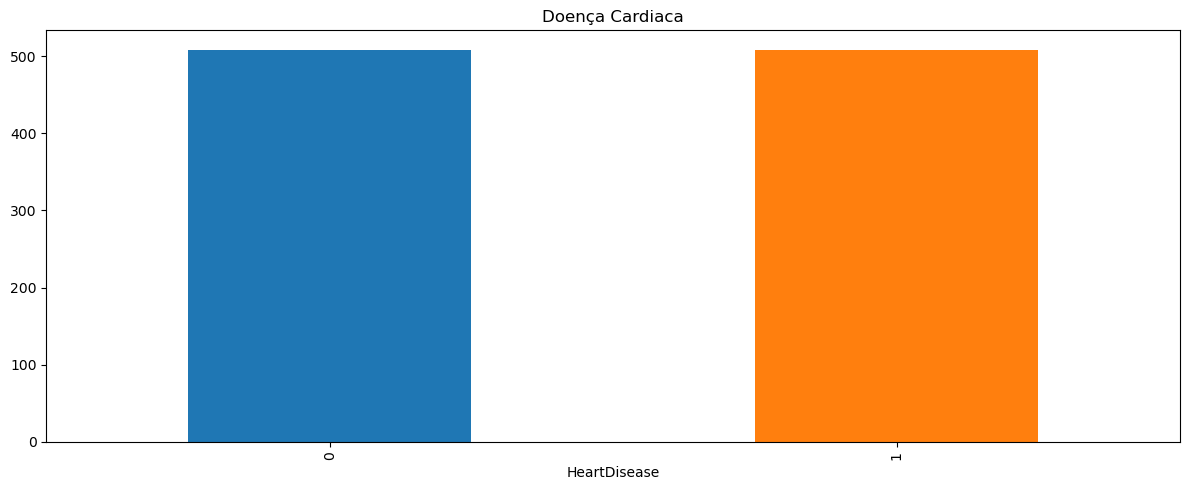

In [53]:
# Visualizando o balanceamento da variável TARGET
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
TARGET_RES.value_counts().plot(kind='bar', title='Doença Cardiaca', color = ['#1F77B4', '#FF7F0E']);

In [54]:
# Visualizando a quantidade da variável target para balanceamentos
variavel_target = TARGET_RES.value_counts()
variavel_target

HeartDisease
0    508
1    508
Name: count, dtype: int64

In [55]:
# Quantidade de registros antes do balanceamento
PREDITORAS.shape

(918, 11)

In [56]:
# Quantidade de registros antes do balanceamento
TARGET.shape

(918,)

In [57]:
# Quantidade de registros após do balanceamento
TARGET_RES.shape

(1016,)

In [58]:
## Agora vamos dividir os dados em dados de treino e teste para iniciarmos a etapa de criação do modelo

In [59]:
# Divisão em Dados de Treino e Teste
x_treino, x_teste, y_treino, y_teste = train_test_split(PREDITORAS_RES, TARGET_RES, test_size = 0.3, random_state = 42)

In [60]:
x_treino.shape

(711, 11)

In [61]:
x_treino.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
177,59,1,1,140,287,0,1,150,0,0.00,2
467,63,0,1,132,0,0,1,130,0,0.10,2
507,40,1,2,106,240,0,1,80,1,0.00,2
486,55,1,1,110,214,1,2,180,0,0.40,2
328,52,1,0,95,0,1,1,82,1,0.80,1


In [62]:
# Normalização das Variáveis
Normalizador = MinMaxScaler()
x_treino_normalizados = Normalizador.fit_transform(x_treino)
x_teste_normalizados = Normalizador.transform(x_teste)

In [63]:
x_treino_normalizados.shape

(711, 11)

In [64]:
# Visualizando os dados NORMALIZADOS
x_treino_normalizados

array([[0.625     , 1.        , 0.33333333, ..., 0.        , 0.31707317,
        1.        ],
       [0.70833333, 0.        , 0.33333333, ..., 0.        , 0.32926829,
        1.        ],
       [0.22916667, 1.        , 0.66666667, ..., 1.        , 0.31707317,
        1.        ],
       ...,
       [0.64583333, 1.        , 0.        , ..., 1.        , 0.48780488,
        1.        ],
       [0.64583333, 1.        , 0.        , ..., 1.        , 0.31707317,
        1.        ],
       [0.22916667, 0.        , 0.        , ..., 0.        , 0.56097561,
        0.5       ]])

In [65]:
x_teste_normalizados.shape

(305, 11)

In [66]:
x_teste_normalizados

array([[0.10416667, 0.        , 0.33333333, ..., 0.        , 0.40243902,
        1.        ],
       [0.70833333, 1.        , 0.        , ..., 1.        , 0.43902439,
        1.        ],
       [0.39583333, 1.        , 0.        , ..., 0.        , 0.31707317,
        0.5       ],
       ...,
       [0.625     , 1.        , 0.66666667, ..., 0.        , 0.51219512,
        1.        ],
       [0.58333333, 1.        , 0.33333333, ..., 0.        , 0.41463415,
        0.5       ],
       [0.39583333, 1.        , 0.66666667, ..., 0.        , 0.31707317,
        1.        ]])

# Criando, Treinando e Avaliando os Modelos de Machine Learning

In [68]:
# Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators = 300, criterion = 'entropy', max_depth = 10,
                             max_features = 'sqrt', min_samples_leaf = 2, min_samples_split = 2, n_jobs = 8) # Alterado aqui!

# Construção do modelo
clf = clf.fit(x_treino_normalizados, y_treino)

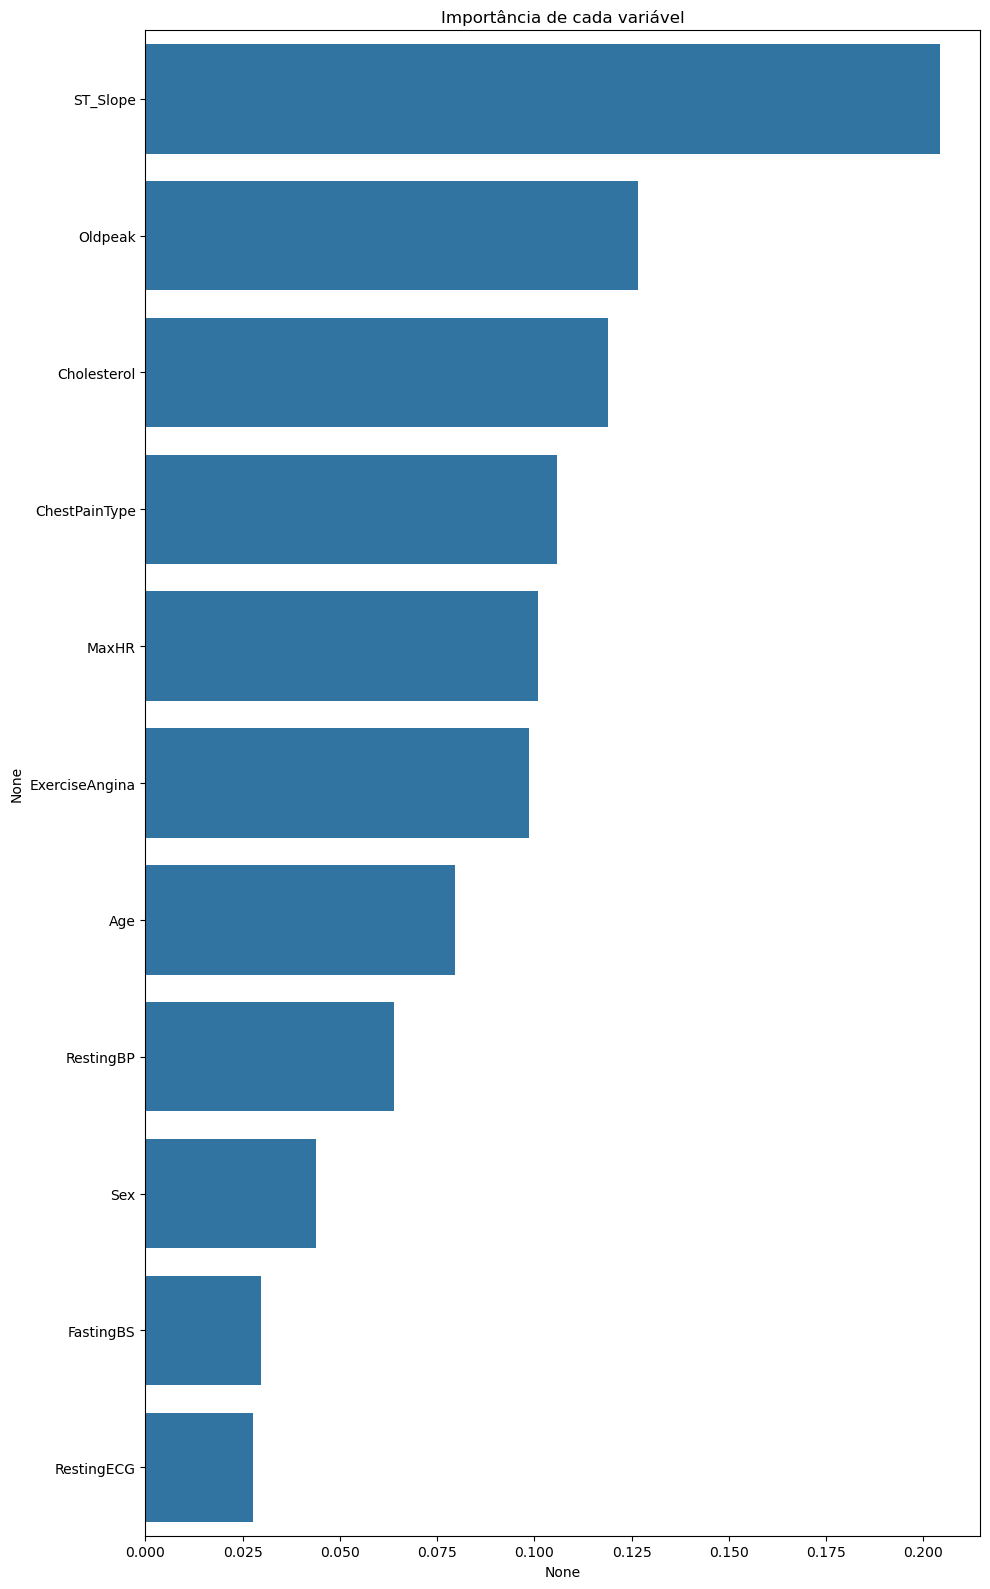

In [69]:
# Exibindo a importancia de cada variavel no modelo preditivo
plt.rcParams["figure.figsize"] = [10.00, 16.00]
plt.rcParams["figure.autolayout"] = True

importances = pd.Series(data=clf.feature_importances_, index=PREDITORAS.columns)
importances = importances.sort_values(ascending = False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de cada variável')
plt.show()

In [134]:
# Visualizando o percentual de importância de cada variável
importances.sort_values(ascending = False)

ST_Slope         0.20
Oldpeak          0.13
Cholesterol      0.12
ChestPainType    0.11
MaxHR            0.10
ExerciseAngina   0.10
Age              0.08
RestingBP        0.06
Sex              0.04
FastingBS        0.03
RestingECG       0.03
dtype: float64

In [136]:
# Estamos apenas "simulando" os dados de teste
scores = clf.score(x_treino_normalizados, y_treino)
scores

0.9662447257383966

In [138]:
# Estamos apenas "simulando" os dados de teste
scores = clf.score(x_teste_normalizados,y_teste)
scores

0.8754098360655738

In [142]:
y_pred = clf.predict(x_teste_normalizados)
print(accuracy_score(y_teste, y_pred)* 100)

87.54098360655738


In [146]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print(confusion_matrix(y_teste, y_pred))

[[118  20]
 [ 18 149]]


In [156]:
from sklearn.metrics import classification_report
print(classification_report(y_teste, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       138
           1       0.88      0.89      0.89       167

    accuracy                           0.88       305
   macro avg       0.87      0.87      0.87       305
weighted avg       0.88      0.88      0.88       305



In [148]:
cm = confusion_matrix(y_teste, y_pred)

In [150]:
print(cm)

[[118  20]
 [ 18 149]]


In [152]:
cm_disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Sim","Não"])

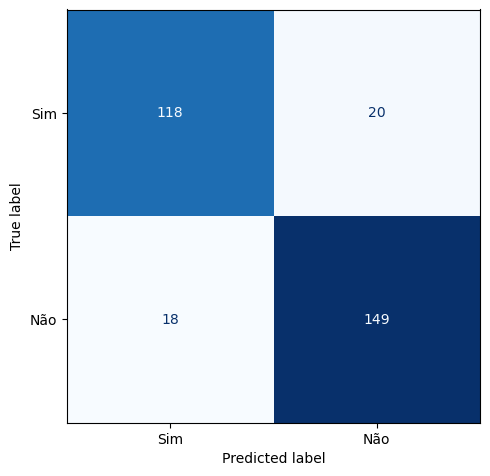

In [154]:
plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True
cm_disp.plot(include_values=True,
             cmap='Blues',
             colorbar=None)

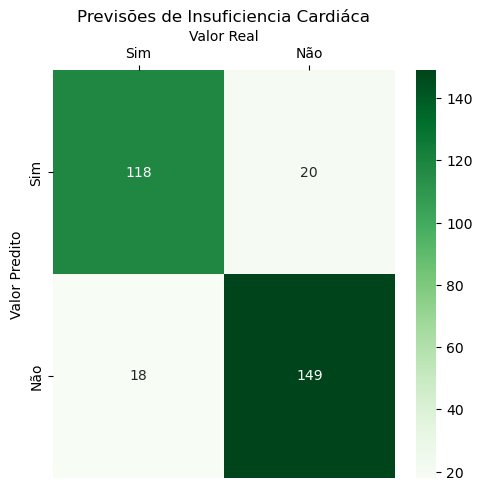

In [160]:
pd.options.display.float_format = '{:.2f}'.format

plt.rcParams["figure.figsize"] = [5.00, 5.00]
plt.rcParams["figure.autolayout"] = True

f, ax = plt.subplots(figsize=(5, 5))

sns.heatmap(cm, 
            cmap = "Greens", 
            annot = True,
            cbar_kws = {"orientation":"vertical"},            
            fmt=".0f",
            xticklabels = ["Sim","Não"],
            yticklabels = ["Sim","Não"])

ax.set_ylabel('Valor Predito')
ax.set_xlabel('Valor Real')

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.title("Previsões de Insuficiencia Cardiáca")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.show()

In [162]:
(118 + 149) / 305

0.8754098360655738